In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
!unzip -q -u "/content/drive/MyDrive/fish_are_mans_friend/data/test_stg1.zip" -d "/content/test_stg1/test_stg1"
# Nested folder so that we can use ImageFolder to load the data in

In [15]:
# Load the data path to images
# Rmb to mount your Gdrive
# IMG_DIR = '/content/drive/MyDrive/2. SUTD/SUTD Term 8/50.021 Artificial Intelligence /fish_are_mans_friend/data/train'
IMG_DIR = '/content/test_stg1'

In [16]:
!pip install lime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [17]:
import pandas as pd 
import matplotlib.pylab as plt
import seaborn as sns
# set as seaborn’s default theme
sns.set_theme()
import glob     
import numpy as np
from PIL import Image
from collections import Counter
import os
import shutil

import torchvision
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, SubsetRandomSampler, random_split
from torchsummary import summary
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from sklearn.model_selection import train_test_split
import torch
# Speeds up convolutions by trying different algorithms for computing convolutions
torch.backends.cudnn.benchmark = True

# Batch Size
BATCH_SIZE = 1

# Label Map
label_map = {
    0: "ALB",
    1: "BET",
    2: "DOL",
    3: "LAG",
    4: "NoF",
    5: "OTHER",
    6: "SHARK",
    7: "YFT",
}


In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform = transforms.Compose([
    # you can add other transformations in this list
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load the training and validation dataset
try:  
  dataset = datasets.ImageFolder(IMG_DIR, transform=transform)
  datasets
  print(dataset)  
except FileNotFoundError:
  raise Exception("Try running cd train and rm -r .ipynb_checkpoints as it causing confusion https://stackoverflow.com/questions/68229246/pytorch-torchvision-datasets-imagefolder-filenotfounderror-found-no-valid-file") 

CLASSES = list(set(dataset.targets))
print([label_map[i] for i in CLASSES])

LIME_dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, num_workers = 2, pin_memory=True)

Dataset ImageFolder
    Number of datapoints: 1000
    Root location: /content/test_stg1
    StandardTransform
Transform: Compose(
               Resize(size=256, interpolation=bilinear, max_size=None, antialias=None)
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )
['ALB']


In [19]:
from lime import lime_image
from skimage.segmentation import mark_boundaries
from google.colab.patches import cv2_imshow
import cv2

def lime(lime_model):

    # define classification function that Lime needs
    def predict_fn(image):
        img = image.transpose((0, 3, 1, 2))
        torch_img = torch.from_numpy(img).float()

        lime_model.eval()

        lime_model.to(device)
        torch_img = torch_img.to(device)
        
        logits = lime_model(torch_img)
        probs = F.softmax(logits, dim=1)
        return probs.detach().cpu().numpy()


    num_iter = 10
    for index, i in enumerate(LIME_dataloader):
        # i = [train_img, labels]

        img = i[0].squeeze().numpy().transpose((1, 2, 0)).astype('double')

        # create explanation for this prediciton
        explainer = lime_image.LimeImageExplainer()
        explanation = explainer.explain_instance(img, 
                                                predict_fn, # classification function
                                                top_labels=5, 
                                                hide_color=0, 
                                                num_samples=100) # number of images that will be sent to classification function

        # use mask on image and see the areas that are encouraging the top prediction.
        temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
        anti_temp, anti_mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)

        # Image with areas that are encouraging the top prediction.
        img_boundry1 = mark_boundaries(temp, mask)
        img_boundry1 = cv2.normalize(img_boundry1, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
        img_boundry1 = cv2.cvtColor(img_boundry1, cv2.COLOR_RGB2BGR)
        cv2_imshow(img_boundry1)

        # Image with areas that contributes against the top prediction.
        img_boundry2 = mark_boundaries(anti_temp, anti_mask)
        img_boundry2 = cv2.normalize(img_boundry2, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
        img_boundry2 = cv2.cvtColor(img_boundry2, cv2.COLOR_RGB2BGR)
        cv2_imshow(img_boundry2)

        if index == num_iter:
            break


  0%|          | 0/100 [00:00<?, ?it/s]

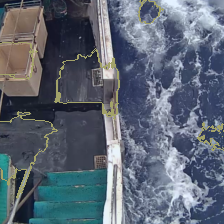

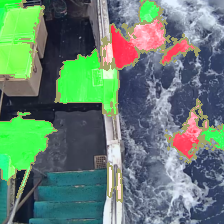

  0%|          | 0/100 [00:00<?, ?it/s]

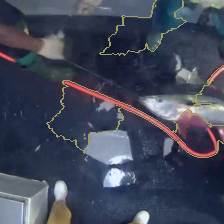

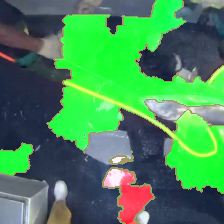

  0%|          | 0/100 [00:00<?, ?it/s]

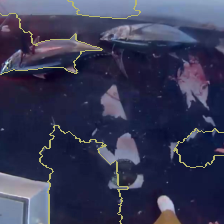

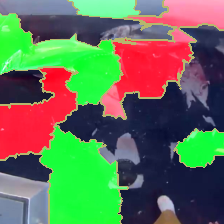

  0%|          | 0/100 [00:00<?, ?it/s]

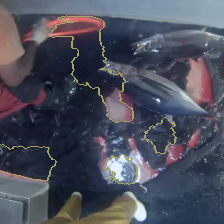

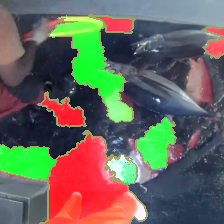

  0%|          | 0/100 [00:00<?, ?it/s]

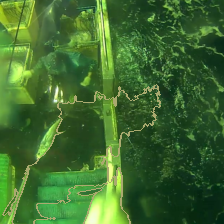

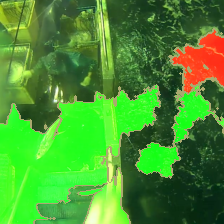

  0%|          | 0/100 [00:00<?, ?it/s]

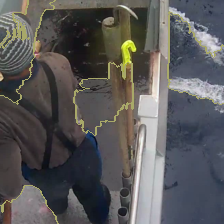

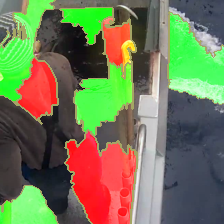

  0%|          | 0/100 [00:00<?, ?it/s]

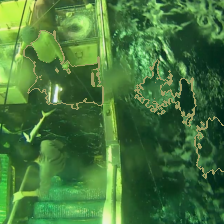

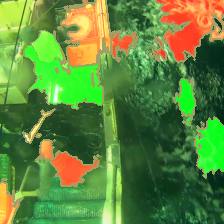

  0%|          | 0/100 [00:00<?, ?it/s]

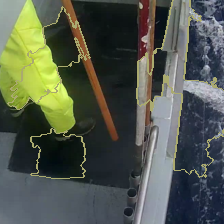

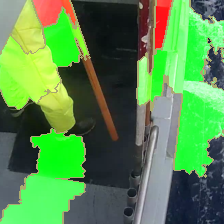

  0%|          | 0/100 [00:00<?, ?it/s]

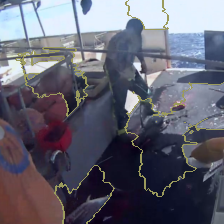

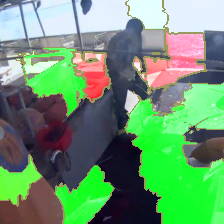

  0%|          | 0/100 [00:00<?, ?it/s]

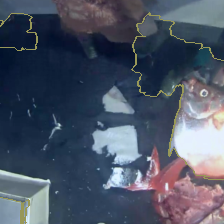

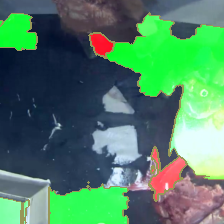

  0%|          | 0/100 [00:00<?, ?it/s]

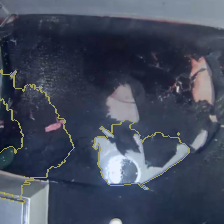

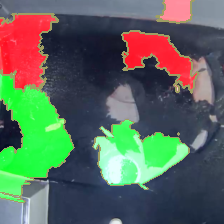

In [22]:
# Load model
# load_path = '/content/drive/MyDrive/2. SUTD/SUTD Term 8/50.021 Artificial Intelligence /fish_are_mans_friend/models/efficientnet_10_25_full.pt'
load_path = "/content/drive/MyDrive/fish_are_mans_friend/models/efficientnet_10_25_full.pt"

modelV1 = torch.load(load_path)
modelV1.eval()

lime(modelV1)

/usr/local/lib/python3.7/dist-packages/torch/hub.py:267: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  "You are about to download and run code from an untrusted repository. In a future release, this won't "
Downloading: "https://github.com/NVIDIA/DeepLearningExamples/zipball/torchhub" to /root/.cache/torch/hub/torchhub.zip
/root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/Classification/ConvNets/image_classification/models/common.py:14: UserWarning: p

  0%|          | 0.00/74.5M [00:00<?, ?B/s]

  0%|          | 0/100 [00:00<?, ?it/s]

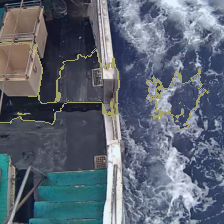

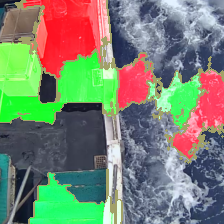

  0%|          | 0/100 [00:00<?, ?it/s]

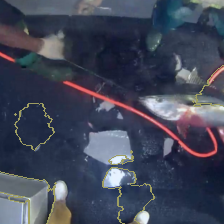

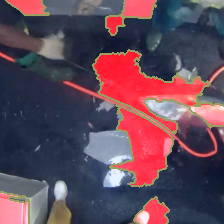

  0%|          | 0/100 [00:00<?, ?it/s]

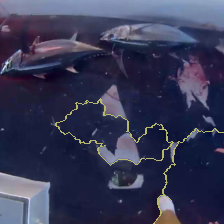

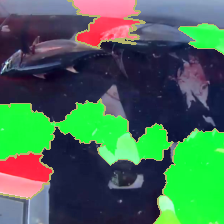

  0%|          | 0/100 [00:00<?, ?it/s]

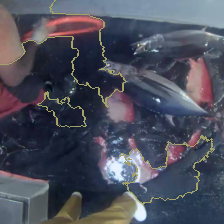

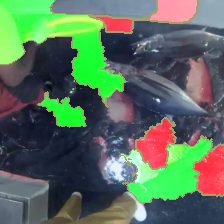

  0%|          | 0/100 [00:00<?, ?it/s]

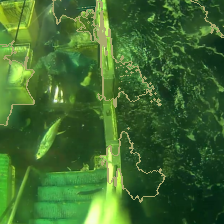

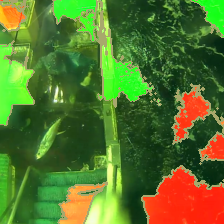

  0%|          | 0/100 [00:00<?, ?it/s]

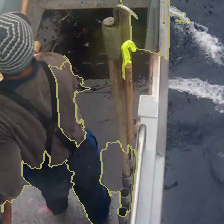

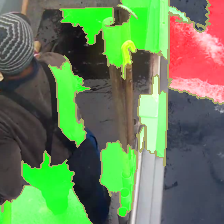

  0%|          | 0/100 [00:00<?, ?it/s]

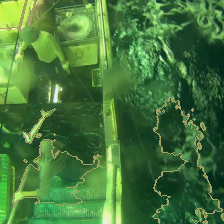

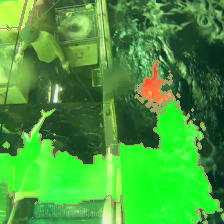

  0%|          | 0/100 [00:00<?, ?it/s]

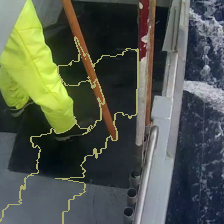

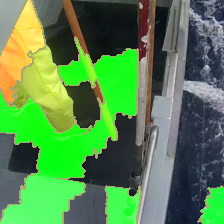

  0%|          | 0/100 [00:00<?, ?it/s]

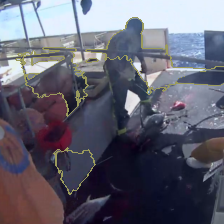

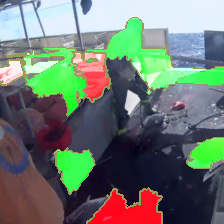

  0%|          | 0/100 [00:00<?, ?it/s]

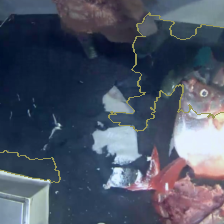

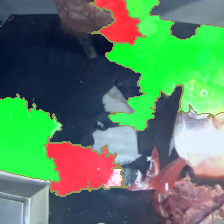

  0%|          | 0/100 [00:00<?, ?it/s]

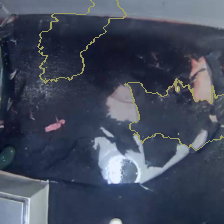

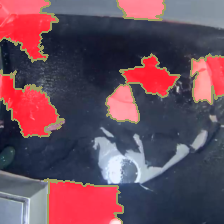

In [21]:
# Load model
# load_path = '/content/drive/MyDrive/2. SUTD/SUTD Term 8/50.021 Artificial Intelligence /fish_are_mans_friend/models/efficientnet_03_full_state_dict.pt'

load_path = "/content/drive/MyDrive/fish_are_mans_friend/models/efficientnet_03_full_state_dict.pt"

efficientnet = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_efficientnet_b4', pretrained=True)

def augment_model(efficientnet):
    efficientnet.classifier[-1] = nn.Linear(in_features=1792, out_features=len(label_map), bias=True)
    return efficientnet

modelV3 = augment_model(efficientnet)
modelV3.load_state_dict(torch.load(load_path))
modelV3.eval()

lime(modelV3)